Dataset downloaded from https://www.kaggle.com/amananandrai/ag-news-classification-dataset

In [1]:
import os
import pandas as pd
import json
import re
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras import Model
from keras.layers import concatenate

In [2]:
df = pd.read_csv('train.csv')

The dataframe has two text columns. We could concatenate them together as a single entry, but common sense tells us they are qualitatively different fields that have their own separate word distributions. Let's build a concetenation model to treat both fields as separate features.

In [3]:
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


We'll keep track of hyperparameters and other useful details related to this run in a text log. Let's define these values as constants here.

In [4]:
NOTES = ''
LEN = len(df)
SPLIT = 0.9
LAYERS = 2
DROPOUT = 0.5
BATCH = 100
EPOCHS = 5
SMOOTHING = 0.1
NODES_1 = 100
NODES_2 = 32
NODES_3 = 0

In [ ]:
The singular feature for the left branch of the modelis stored in the variable X. The one-hot encoded output variable

In [5]:
log = pd.read_csv('text_and_title.csv')

X = df['Description']
Y = pd.get_dummies(df['Class Index'])

X2 = df['Title']

In [6]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=None)

encoder.adapt(X)

encoder2 = tf.keras.layers.TextVectorization(
    max_tokens=None)

encoder2.adapt(X2)

In [7]:
mod = tf.keras.Sequential()

mod.add(tf.keras.Input(shape=(1,), dtype=tf.string))
mod.add(encoder)
mod.add(tf.keras.layers.Embedding(len(encoder.get_vocabulary()), NODES_1, mask_zero=True))
mod.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(NODES_1,  return_sequences=True)))
mod.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(NODES_2)))

In [8]:
mod2 = tf.keras.Sequential()

mod2.add(tf.keras.Input(shape=(1,), dtype=tf.string))
mod2.add(encoder2)
mod2.add(tf.keras.layers.Embedding(len(encoder.get_vocabulary()), NODES_1, mask_zero=True))
mod2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(NODES_1,  return_sequences=True)))
mod2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(NODES_2)))

In [9]:
model_concat = concatenate([mod.output,mod2.output])
model_concat = tf.keras.layers.Dense(NODES_2, activation='relu')(model_concat)
model_concat = tf.keras.layers.Dropout(DROPOUT)(model_concat)
model_concat = tf.keras.layers.Dense(Y.shape[1], activation='softmax')(model_concat)

model = Model(inputs=[mod.input, mod2.input], outputs=model_concat)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=SMOOTHING, from_logits=False),
            optimizer=tf.keras.optimizers.Adam(1e-4),
            metrics=([tf.keras.metrics.CategoricalCrossentropy(name='CatCrossentropy'), 
            tf.keras.metrics.CategoricalAccuracy(name='CatAccuracy'),
            tf.keras.metrics.Recall(name='Recall')]))

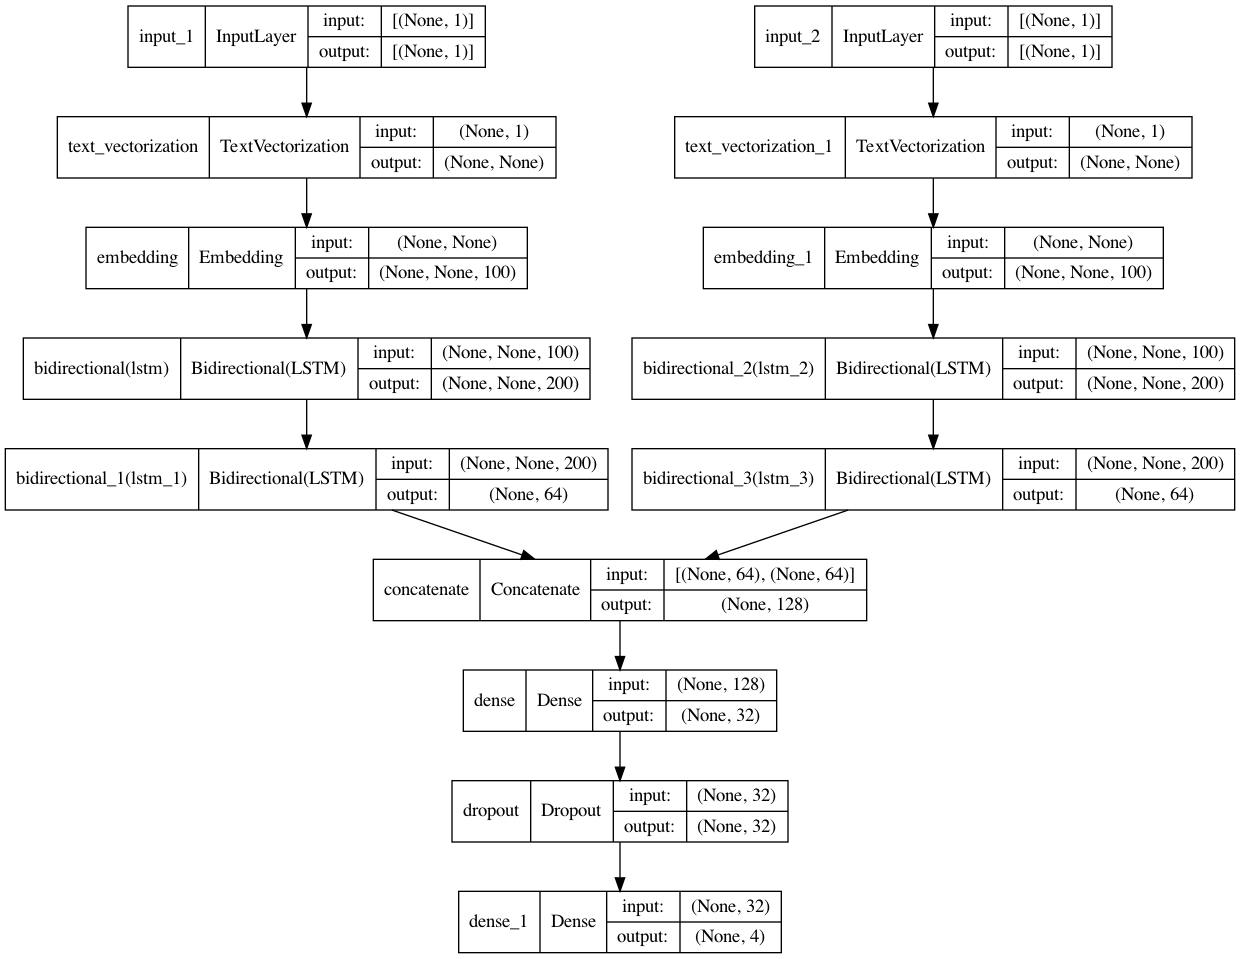

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, None)        0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, None)        0           ['input_2[0][0]']            

In [12]:
history = model.fit(x=[X.values, X2.values], y=Y.values, batch_size = BATCH, epochs=EPOCHS,
    validation_split=SPLIT, verbose=True)

Epoch 1/5
120/120 [==============================] - 176s 1s/step - loss: 1.3794 - CatCrossentropy: 1.3786 - CatAccuracy: 0.3280 - Recall: 0.0000e+00 - val_loss: 1.3639 - val_CatCrossentropy: 1.3613 - val_CatAccuracy: 0.3841 - val_Recall: 0.0000e+00
Epoch 2/5
120/120 [==============================] - 177s 1s/step - loss: 1.1380 - CatCrossentropy: 1.0863 - CatAccuracy: 0.5865 - Recall: 0.2100 - val_loss: 0.9869 - val_CatCrossentropy: 0.9067 - val_CatAccuracy: 0.6754 - val_Recall: 0.4068
Epoch 3/5
120/120 [==============================] - 177s 1s/step - loss: 0.8121 - CatCrossentropy: 0.6681 - CatAccuracy: 0.8068 - Recall: 0.6397 - val_loss: 0.8362 - val_CatCrossentropy: 0.6970 - val_CatAccuracy: 0.7552 - val_Recall: 0.6666
Epoch 4/5
120/120 [==============================] - 201s 2s/step - loss: 0.6593 - CatCrossentropy: 0.4605 - CatAccuracy: 0.8897 - Recall: 0.8043 - val_loss: 0.7650 - val_CatCrossentropy: 0.6037 - val_CatAccuracy: 0.7940 - val_Recall: 0.7232
Epoch 5/5
120/120 [=====

In [13]:
pred = model.predict([df['Description'], df['Title']])
pred = pd.Series(np.argmax(pred, axis=1))
pred += 1
df['pred'] = pred


ACC = len(df[df['pred']==df['Class Index']])/len(df)
print(ACC)

0.8132583333333333


In [14]:
row = {'accuracy': ACC, 'notes': NOTES, 'len': LEN,
    'split': SPLIT, 'layers': LAYERS, 'dropout': DROPOUT,
    'batch': BATCH, 'epochs': EPOCHS, 'smoothing': SMOOTHING,
    'nodes1': NODES_1, 'nodes2': NODES_2, 'nodes3': NODES_3}

print(row)

log = log.append(row, ignore_index=True)
log.to_csv('text_and_title.csv', index=False)

{'accuracy': 0.8132583333333333, 'notes': '', 'len': 120000, 'split': 0.9, 'layers': 2, 'dropout': 0.5, 'batch': 100, 'epochs': 5, 'smoothing': 0.1, 'nodes1': 100, 'nodes2': 32, 'nodes3': 0}


This model gets a max accuracy of .81, versus 0.78 for the description-only model. Not extraordinary, but it's not nothing!